##Importing the required libraries and regressor models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

##Loading the data

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('/content/PJMW_hourly.csv')

# Set the 'Datetime' column as the index
df = df.set_index('Datetime')

# Convert the index to datetime format
df.index = pd.to_datetime(df.index)


##Display the data

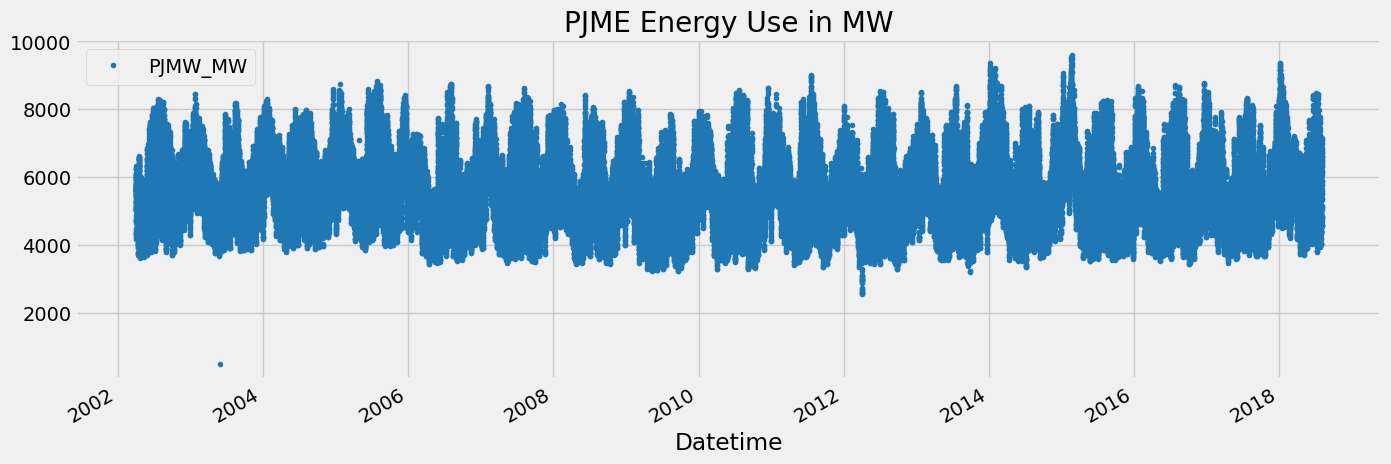

In [9]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

##Conducting Outlier Analysis and removal

<Axes: ylabel='Frequency'>

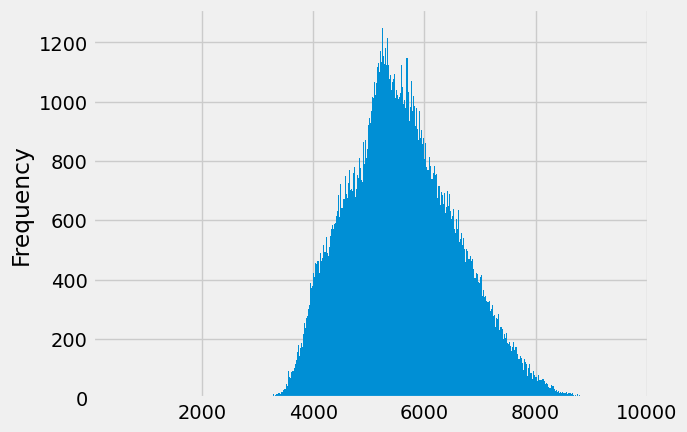

In [11]:
df['PJMW_MW'].plot(kind='hist', bins=500)

In [ ]:
df.query('PJMW_MW < 3_000')['PJMW_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [17]:
df = df.query('PJMW_MW > 3_000').copy()

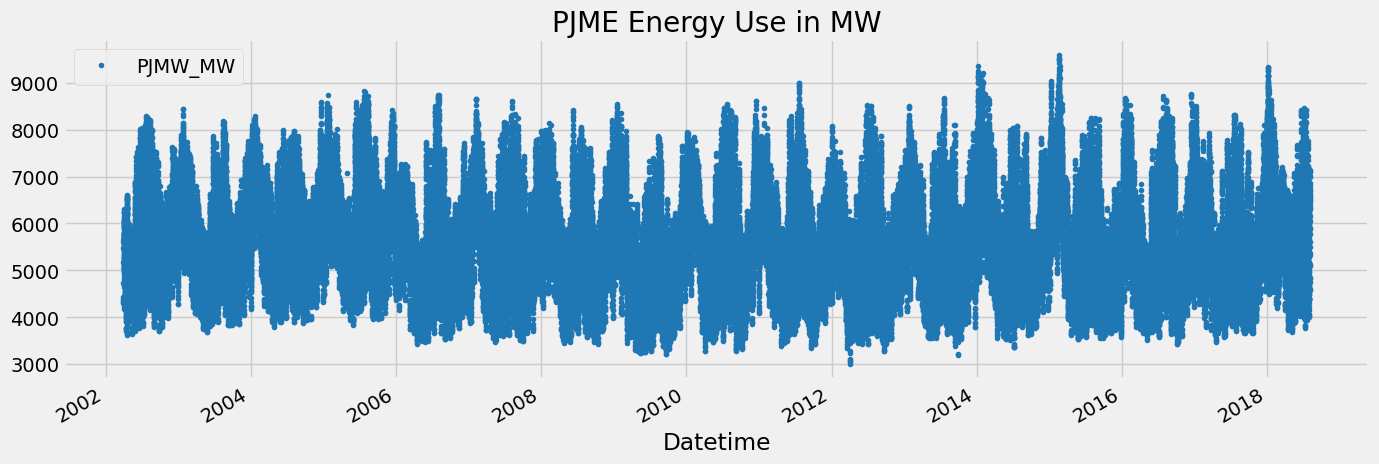

In [21]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')

plt.show()

##Visualising the Train and Test Set

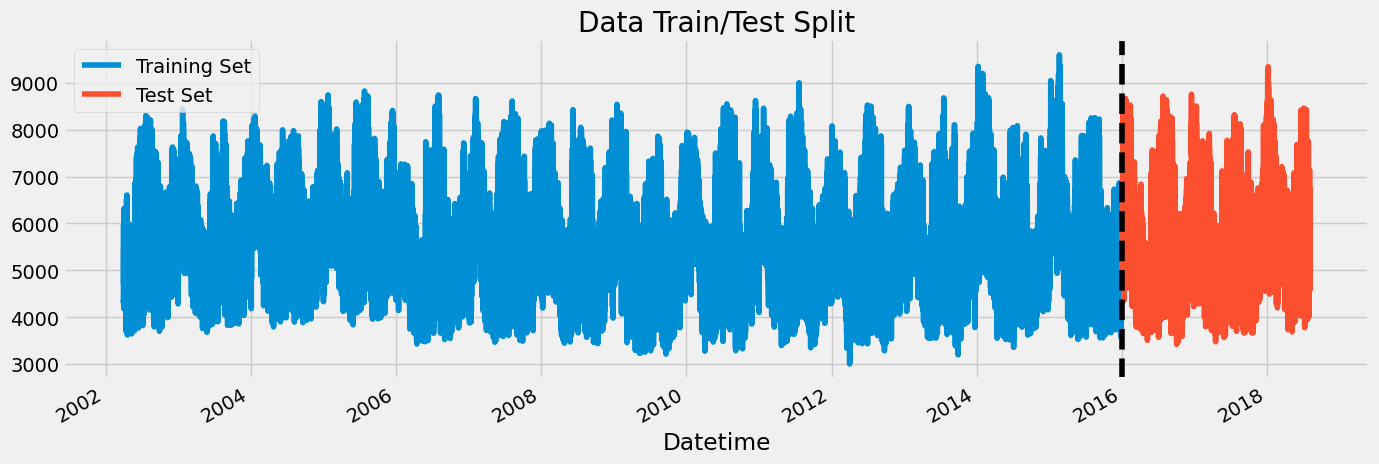

In [26]:
# Split the data into training and test sets based on the specified date
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the training set
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')

# Plot the test set
test.plot(ax=ax, label='Test Set')

# Add a vertical line to indicate the separation between train and test sets
ax.axvline('01-01-2016', color='black', ls='--')

# Add legend to the plot
ax.legend(['Training Set', 'Test Set'])

# Display the plot
plt.show()


Here we visualise the train and test set using Time Series Cross ValidationSplit. The reason we use this over normal cross validation rechniques i because we don't want to essentially train the algorith on future data to predict the past as

1) Not useful in most cases

2) There is data leakage from the past into the future

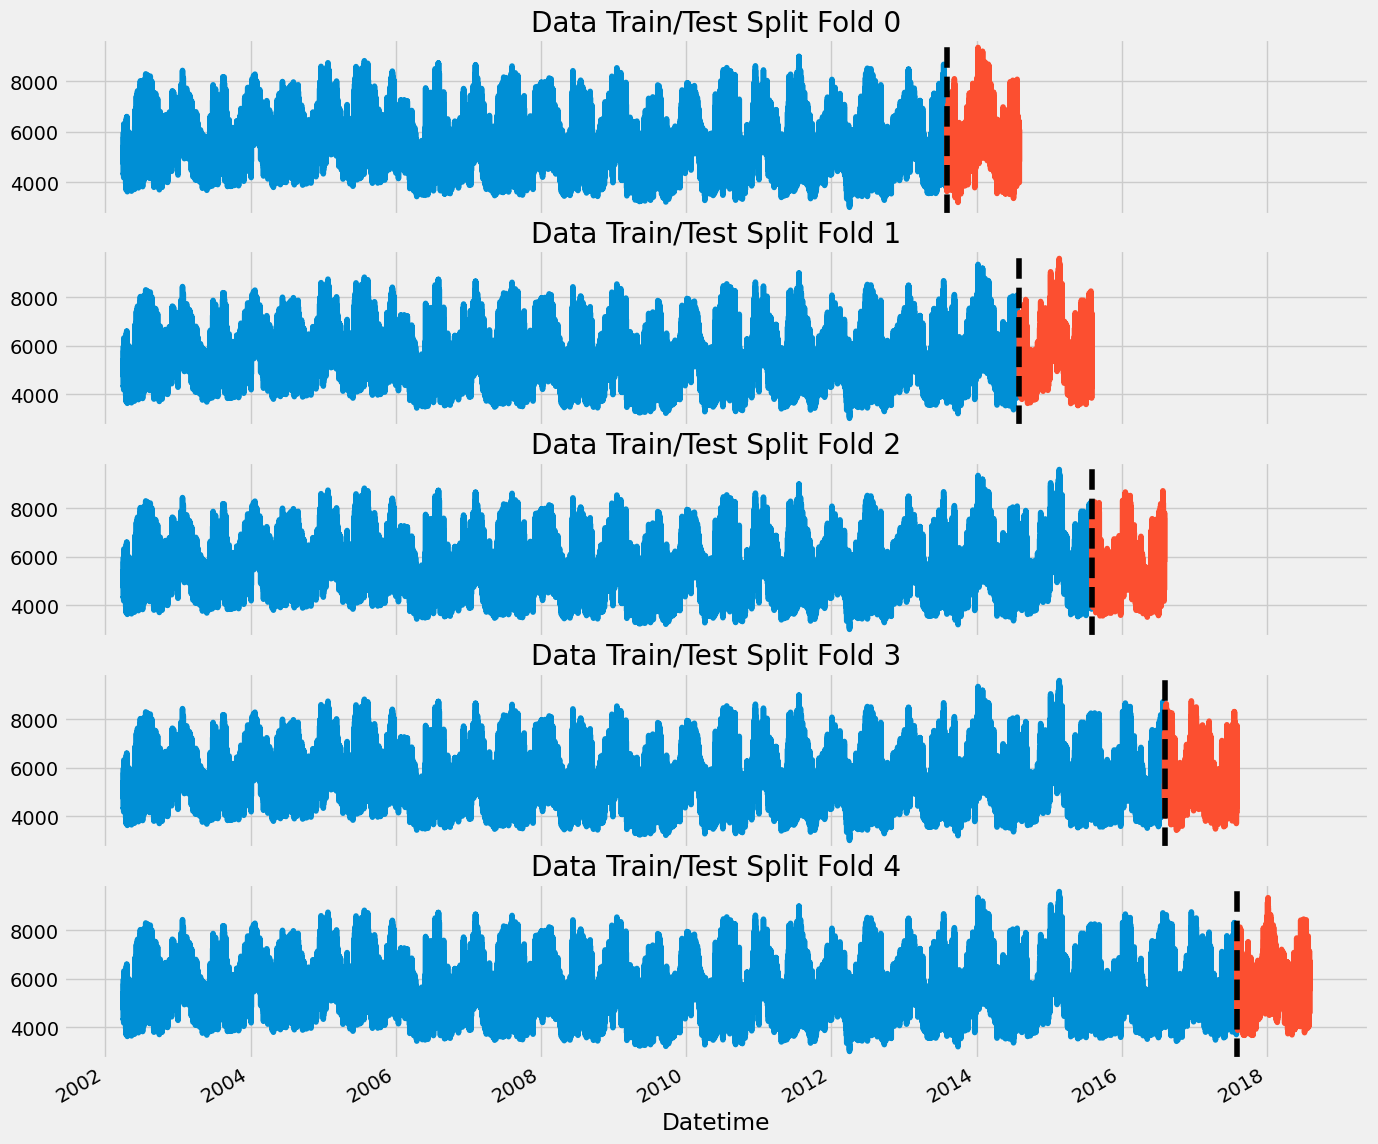

In [28]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit object
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

# Sort the dataframe by index
df = df.sort_index()

# Create a figure with subplots
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    # Split the data into training and test sets based on indices
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # Plot the training set
    train['PJMW_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')

    # Plot the test set
    test['PJMW_MW'].plot(ax=axs[fold],
                         label='Test Set')

    # Add a vertical line to indicate the separation between train and test sets
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    # Increment the fold counter
    fold += 1

# Display the subplots
plt.show()


Performing Feature Engineeing on the dataset

In [29]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    # Create a copy of the dataframe
    df = df.copy()

    # Extract various time-based features from the index
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Return the modified dataframe
    return df

# Call the create_features function to add time-based features to the dataframe
df = create_features(df)


In [30]:
df.head()

,PJMW_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-04-01 01:00:00,4374.0,1,0,2,4,2002,91,1,14
2002-04-01 02:00:00,4306.0,2,0,2,4,2002,91,1,14
2002-04-01 03:00:00,4322.0,3,0,2,4,2002,91,1,14
2002-04-01 04:00:00,4359.0,4,0,2,4,2002,91,1,14
2002-04-01 05:00:00,4436.0,5,0,2,4,2002,91,1,14


##Adding Lag Features

This basically allows to add the value of the target variable at aparticular lag (into the past - say 1 month) as an added feature for predicting the target variable.

This is also known as ACF (Autocorrelation Function)

In [33]:
def add_lags(df):
    # Create a dictionary mapping timestamps to target values
    target_map = df['PJMW_MW'].to_dict()

    # Add lagged columns to the dataframe
    # The lags are calculated by subtracting specific time durations from the current timestamp
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)  # Lag 1: 364 days (1 year) ago
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)  # Lag 2: 728 days (2 years) ago
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)  # Lag 3: 1092 days (3 years) ago

    return df

df = add_lags(df)

Now we train the regressor on the train and val sets using the time series train test split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit object
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)  # using 24 hrs * 365 days * 1 year as validation set size

# Sort the dataframe by index
df = df.sort_index()

fold = 0
preds = []  # List to store predictions for each fold
scores = []  # List to store scores (root mean squared error) for each fold

# Loop through each fold
for train_idx, val_idx in tss.split(df):
    # Split the data into training and test sets based on indices
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # Create features for training and test sets
    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
                'lag1', 'lag2', 'lag3']  # List of feature columns
    TARGET = 'PJMW_MW'  # Target column name

    X_train = train[FEATURES]  # Training set features
    y_train = train[TARGET]  # Training set target

    X_test = test[FEATURES]  # Test set features
    y_test = test[TARGET]  # Test set target

    # Initialize XGBoost regressor with desired parameters
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=4,
                           learning_rate=0.01)

    # Fit the regressor to the training data
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    # Make predictions on the test set
    y_pred = reg.predict(X_test)
    preds.append(y_pred)  # Store predictions for this fold
    score = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate root mean squared error
    scores.append(score)  # Store score for this fold


In [40]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 644.3854
Fold scores:[642.5971651670034, 592.9376709602592, 625.5912989249805, 671.0141663979218, 689.7866683101383]


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [48]:
# Retrain on all data
df = create_features(df)  # Preprocess the data and create additional features

# Define the features and target variable
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
TARGET = 'PJMW_MW'

X_all = df[FEATURES]  # Features
y_all = df[TARGET]    # Target variable

# Initialize the XGBoost regressor
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=4,
                       learning_rate=0.01)

# Fit the regressor to the data
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[18:14:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5630.90877
[100]	validation_0-rmse:2137.75380
[200]	validation_0-rmse:948.10356
[300]	validation_0-rmse:617.59276
[400]	validation_0-rmse:544.56154
[499]	validation_0-rmse:524.05908


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [43]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

##Creating a dataset for future datestamps and concatenating with the exusting dataframe

In [44]:
# Create future dataframe
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)

# Add a column 'isFuture' to indicate future data points
future_df['isFuture'] = True

# Add a column 'isFuture' to the existing dataframe (df) to indicate non-future data points
df['isFuture'] = False

# Concatenate the existing dataframe (df) and future dataframe (future_df)
df_and_future = pd.concat([df, future_df])

# Perform feature engineering on the combined dataframe
df_and_future = create_features(df_and_future)

# Add lagged features to the dataframe
df_and_future = add_lags(df_and_future)


##Performing the prediction on the future dataset only

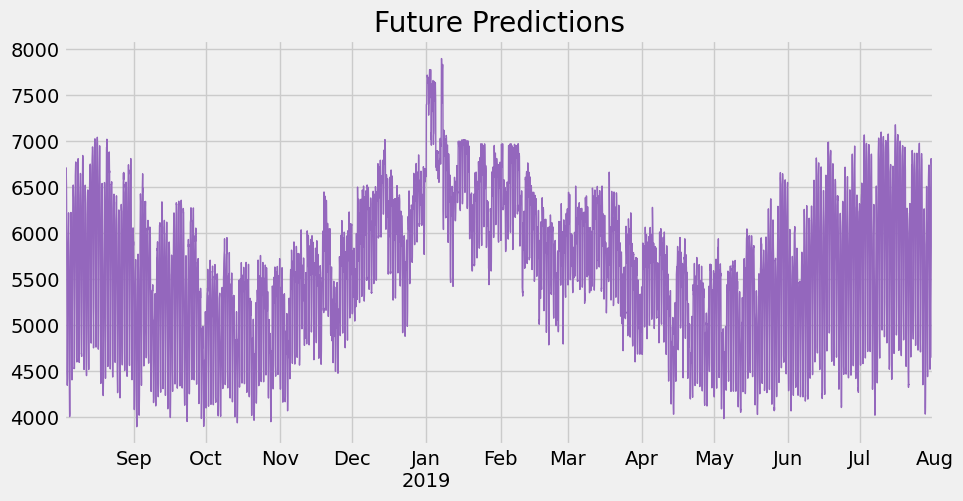

In [51]:
# Select the future records from the dataframe and create a copy
future_w_features = df_and_future.query('isFuture').copy()

# Perform regression to predict values using the trained model 'reg'
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

# Plot the predicted values
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')

# Display the plot
plt.show()
